### This notebook contains the following content:
* [1. Motivation for Linear Regression](#first-bullet)
* [2. Groundwork for Single Feature RSS Regression](#second-bullet)
* [3. Optimisation of RSS function](#third_bullet)
* [4. Expansion to Multiple Features](#fourth-bullet)

## 1. Motivation for Linear Regression <a class="anchor" id="first-bullet"></a>
Linear Regression is possibly one of the most commonly used machine learning algorithms. One major factor in this is the easily interpretable models that are produced. 

Linear Regression is the process of determining a linear relationship between a set of features and an output or target feature. It's worth noting that the relationship between the target and feature is assumed to be linear, but we could use features that are non-linear with respect to other features like for example the square of another feature. This is still termed linear regression.

To provide an example: We may have details on the size, age, neighborhood crime rate and sale price of some houses. We could use linear regression to determine an estimate of how the sale price (our target variable) varies with respect to each of the other features. Then if, for example, a house not in our data set goes up for sale but the owner is unsure of how much they should sell it for, the relationships estimated by linear regression could be used to make a prediction of the previously unseen house' sale price.

For each house in our dataset we have features **$x_{1}$**, **$x_{2}$** etc. up to the number of features and **y** as the independent variable.

## 2. Groundwork for Single Feature RSS Regression <a class="anchor" id="first-bullet"></a>
Let's take a step back for a second and reduce the problem to having a single feature and single target feature. The equation for a line relating variable x to target y can be written as:

\begin{align}
y & = mx + c
\end{align}

Where m is the gradient of the line and c is the intercept term. Let's look at some sample data:

In [1]:
import numpy as np # using numpy to generate fake data
import matplotlib.pyplot as plt # import pyplot so we can plot some graphs
# ensure that plotted graphs appear inline
%matplotlib inline 
np.random.seed(5) # set a random seed so that we get reproducible results

In [2]:
x_data = np.linspace(0,100, num=50) # Create 50 points linearly spaced between 0 and 100
x_noise = 10* np.random.random_sample(x_data.shape) # Create some random values between 0 and 10
x_data = x_data + x_noise # add the noise signal to the linear points
y_data = np.linspace(0,100, num=50) # Create 50 points linearly spaced between 0 and 100
y_noise = 15* np.random.random_sample(y_data.shape) # Create some random values between 0 and 15
y_data = y_data - y_noise # subtract the noise signal from the linear points

Text(0.5,1,'Plot of generated data')

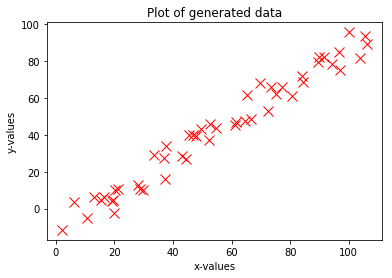

In [3]:
plt.style.use('seaborn-colorblind') # set a style so we get reasonable looking graphs
plt.plot(x_data, y_data, 'rx', markersize=10, label='Data') # plot the y-data vs the x-data
plt.xlabel('x-values')
plt.ylabel('y-values')
plt.title('Plot of generated data')

In the data we can see a roughly linear relationship between the x-values and the y-values. How would we go about fitting a line that **best fits** the data? Here are some options:

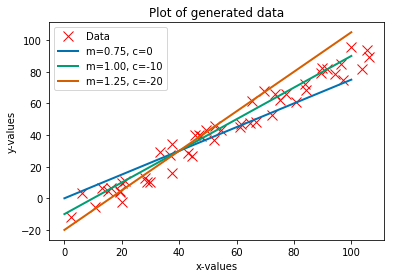

In [4]:
x_line = np.linspace(0,100,num=10) #create perfect x data for line plotting
m = [0.75, 1.0, 1.25] # list of gradients
c = [0, -10, -20] #list of intercepts
plt.plot(x_data, y_data, 'rx', markersize=10, label='Data') # plot the y-data vs the x-data
for m, c in zip(m,c):
    y_line = (x_line * m) + c
    plt.plot(x_line, y_line, '-', label='m=%.2f, c=%d' % (m,c), linewidth=2)
plt.xlabel('x-values')
plt.ylabel('y-values')
plt.title('Plot of generated data')
plt.legend()

All 3 of these lines are possible approximations of the dataset we are looking at. We need to define some metric that indicates how well each line fits the data so that we can compare lines.

### Possible metrics:
**Sum of residuals:** Take the vertical distance from each actual data point to the line (i.e. the 'approximated' value for a particular data point minus the 'actual' value). Sum these residuals for every data point.
 - This has some issues. We  would get some positive values and some negative values so they partially cancel each other out. You could have lots of values that are very far from the line but as long as they are equally distributed above and below the line the sum would be low.
 
**Sum of absolute residuals:** drop the signs of the residuals before summing.
 - This solves the issue above, however another issue is that the residual of points close to the line and points very far from the line are equally weighted.
 
**Sum of residuals squared:** This is the most commonly used technique. Squaring the values makes everything the same sign (positive) and larger values when squared contribute more to the sum. This is commonly referred to as RSS or Residual Sum of Squares.
 - There are other possibilities such as **Mean Squared Error** but the most commonly used for linear regression is RSS.

I will zoom in on the above graph and show the residuals for 1 line.

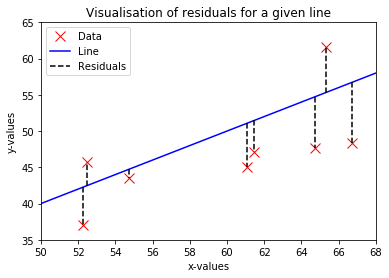

In [5]:
m=1 # gradient of middle line on above graph
c=-10 # intercept of middle line on above graph
y_line = m * x_line + c
y_predicted = (x_data * m) + c # predict values at all our known x points 
plt.plot(x_data, y_data, 'rx', markersize=10, label='Data') # plot the y-data vs the x-data
plt.plot(x_line, y_line, 'b-', label = 'Line')
for index, x_val in enumerate(x_data):
    x_resid=[x_val, x_val] # create 2 x points at the same axial position
    y_resid =[y_predicted[index], y_data[index]] # get the corresponding predicted and actual y values
    plt.plot(x_resid, y_resid, 'k--', label='Residuals')
plt.xlabel('x-values')
plt.ylabel('y-values')
plt.xlim((50,68))
plt.ylim((35,65))

# The following code removes duplicate legend labels (since each vertical line would get it's own legend entry)
handles, labels = plt.gca().get_legend_handles_labels()
i =1
while i<len(labels):
    if labels[i] in labels[:i]:
        del(labels[i])
        del(handles[i])
    else:
        i +=1
# Show the legend
plt.title('Visualisation of residuals for a given line')
plt.legend(handles, labels)

More formally then, our measure of the total fit is:
\begin{equation*}
Cost = \sum_{i=1}^n(y_i - \hat{y}_i)^2
\end{equation*}

Where $y_{i}$ is the actual target value of data point i and $\hat{y}_{i}$ is the value of the line at $x = x_{i}$ (i.e. the target value as predicted by the line). We can write $\hat{y}_{i}$ in terms of the parameters of the line and $x_{i}$ :
\begin{equation*}
Cost = \sum_{i=1}^n(y_i - (m x_i + c))^2
\end{equation*}

This is termed a cost function because a **lower** value is better. We could easily write a function that computes the cost for a given gradient and intercept value. I've written a function to do this below and computed the RSS for the 3 lines we plotted earlier.

In [6]:
def compute_RSS_simple(x_actual, y_actual, gradient, intercept):
    """Takes numpy arrays containing the x and y values of a dataset 
    and the gradient and intercept of a line and calculates the 
    Residual Sum of Squares for this line and dataset."""
    
    y_pred = (x_actual * gradient) + intercept
    residuals = y_actual - y_pred
    residuals_squared = residuals ** 2
    RSS = residuals_squared.sum()
    
    return RSS

m = [0.9, 1.0, 1.1] # list of gradients
c = [-5, -10, -15] #list of intercepts
for gradient, intercept in zip(m, c):
    print('The line with gradient %.2f and intercept %d had an RSS of %.2f' % \
         (gradient, intercept, compute_RSS_simple(x_data, y_data, gradient, intercept)))
    

The line with gradient 0.90 and intercept -5 had an RSS of 1974.77
The line with gradient 1.00 and intercept -10 had an RSS of 1794.86
The line with gradient 1.10 and intercept -15 had an RSS of 2536.25


This gives us an easy way to compare multiple lines and determine which is the best fit (in this case the line with gradient 1 and intercept -10). We could potentially try lots of different gradient and intercept values and keep the ones that give the smallest RSS, but we aren't guaranteed to find the **optimum** parameters. 

### 3. Optimisation of RSS function <a class="anchor" id="third-bullet"></a>

It turns out that if you were to plot a 3-dimensional plot with the first 2 dimensions being the gradient and intercept and the 3rd dimension being the RSS, the shape of the plot would be like a bowl with a defined minimum (this is called a convex function). If you were to take a 'slice' through the plot perpendicular to either the gradient axis or the intercept axis the resulting plot would be U-shaped. See example below:

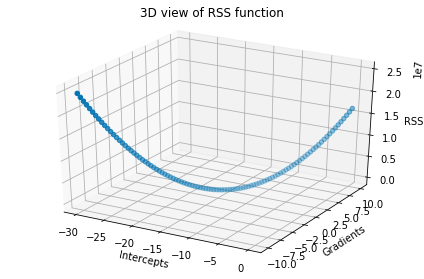

In [7]:
gradients = np.linspace(-10, 10, num=100) # create a list of gradients
intercepts = np.linspace(-30, 0. ,num=100) # create a list of intercepts
RSS = np.zeros_like(intercepts) # create an empty array to store RSS values in
for index, (gradient, intercept) in enumerate(zip(gradients, intercepts)):
    RSS[index] = compute_RSS_simple(x_data, y_data, gradient, intercept)
    
from mpl_toolkits.mplot3d import Axes3D # import 3D plotting tool
fig =plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(intercepts, gradients, RSS)
# This produces a single line in the 3D space but is enough to demonstrate the point
ax.set_xlabel('Intercepts')
ax.set_ylabel('Gradients')
ax.set_zlabel('RSS')
ax.set_title('3D view of RSS function', y=1.05)
fig.tight_layout()

Text(0,0.5,'RSS')

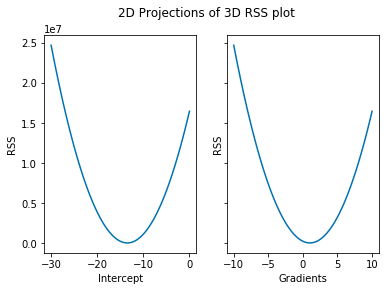

In [8]:
# and now plot both 2D projections
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,)
f.suptitle('2D Projections of 3D RSS plot')
ax1.plot(intercepts, RSS)
ax1.set_xlabel('Intercept')
ax1.set_ylabel('RSS')
ax2.plot(gradients, RSS)
ax2.set_xlabel('Gradients')
ax2.set_ylabel('RSS')

This kind of convex plot has a nice property in that if you are to the left of the minimum the gradient will always be negative and if you are to the right of the minimum the gradient will always be positive.

One way to find the minimum is to form an equation for the gradient and set that equation equal to zero (the **closed form** solution). 
\begin{equation*}
RSS = \sum_{i=1}^n(y_i - (m x_i + c))^2 \\
\frac{\partial RSS}{\partial m} = \sum_{i=1}^n\frac{\partial}{\partial m}(y_i - (m x_i + c))^2 \\
1. \frac{\partial RSS}{\partial m} = -2\sum_{i=1}^n (y_i - (m x_i + c))(x_i) \\
\frac{\partial RSS}{\partial c} = \sum_{i=1}^n\frac{\partial}{\partial c}(y_i - (m x_i + c))^2 \\
2. \frac{\partial RSS}{\partial c} =-2\sum_{i=1}^n (y_i - (m x_i + c)) \\
\end{equation*}

Setting equations 1 and 2 equal to zero allow us to rearrange and substitute. Starting with equation 2:
\begin{equation*}
\sum_{i=1}^n c =\sum_{i=1}^n y_i -  \sum_{i=1}^n m x_i \\
Since \sum_{i=1}^n (constant) = n (constant)  \\
And \sum_{i=1}^n (constant)x_i = (constant) \sum_{i=1}^n x_i \\
nc = \sum_{i=1}^n y_i - m \sum_{i=1}^n x_i \\
3. c = \dot{y} - m \dot{x} \\
\end{equation*}

And now equation 1:
\begin{equation*}
0 = \sum_{i=1}^n y_i x_i - c \sum_{i=1}^n x_i - m \sum_{i=1}^n (x_i)^2 \\
\end{equation*} 
Substitute in c from equation 3:
\begin{equation*}
0 = \sum_{i=1}^n y_i x_i - \dot{y} \sum_{i=1}^n x_i + m \dot{x} \sum_{i=1}^n x_i - m \sum_{i=1}^n (x_i)^2 \\
m = \frac{\sum_{i=1}^n y_i x_i - \dot{y} \sum_{i=1}^n x_i}{\sum_{i=1}^n (x_i)^2 - \dot{x} \sum_{i=1}^n x_i} \\
\end{equation*}

With that out of the way, you'll notice that m can be calculated explicitly from the data that we have and c can be calculated explicitly once we have m. One other note is that by rearranging equation 3 you will see that the regression line **always** passes through the point ($\dot{x}$, $\dot{y}$)

Let's write a function that calculates the closed form solution given a set of x and y values:

In [9]:
def simple_closed_regression(x_values, y_values):
    """This function takes in 2 numpy arrays and returns the gradient
    and intercept calculated from the closed form solution"""
    # First calculate the values for the individual expressions
    sum_x = x_values.sum()
    sum_xy = (x_values * y_values).sum()
    sum_x_squared = (x_values ** 2).sum()
    mean_x = x_values.mean()
    mean_y = y_values.mean()
    
    # Then calculate the numerator and denominator
    # I've split it up for clarity
    m_numerator = sum_xy - (mean_y * sum_x)
    m_denom = sum_x_squared - (mean_x * sum_x)
    m = m_numerator/m_denom
    c = mean_y - (m * mean_x)
    
    # Return the gradient and intercept in a tuple
    return (m, c)

#cf is short for closed-form
cf_gradient, cf_intercept = simple_closed_regression(x_data, y_data)
print('The calculated gradient is %.2f and intercept is %.2f' % (cf_gradient, cf_intercept))

The calculated gradient is 0.98 and intercept is -11.32


Let's plot this on our original scatter plot and see if it looks right.

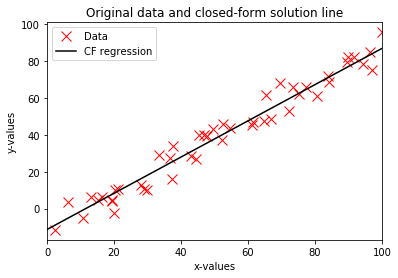

In [10]:
plt.plot(x_data, y_data, 'rx', markersize=10, label='Data') # plot the y-data vs the x-data
x_line = np.linspace(0,100,num=10) #create perfect x data for line plotting
y_line = (cf_gradient * x_line) + cf_intercept
plt.plot(x_line, y_line, 'k-', label='CF regression') # plot the regression line
plt.xlim((0,100))
plt.xlabel('x-values')
plt.ylabel('y-values')
plt.title('Original data and closed-form solution line')
plt.legend()

Looking at the fit of the line to the data, we can be quite confident that our closed form solution is working correctly. Another possible way to solve this is to use **Gradient Descent**.

We showed earlier that the RSS function is convex and has a single global minimum. Gradient descent is an algorithm that uses this fact to calculate the 'downhill' direction from the current point and move a step in that direction. Remember our equations for the gradient of RSS:

\begin{equation*}
\nabla RSS(m, c)= \begin{vmatrix}
\frac{\partial RSS}{\partial m} = -2\sum_{i=1}^n (y_i - (m x_i + c))(x_i) \\
\frac{\partial RSS}{\partial c} =-2\sum_{i=1}^n (y_i - (m x_i + c))
\end{vmatrix}
\end{equation*}

The $\nabla$ symbol represents the gradient of the function in the 2 directions m and c.

If we were to guess an initial m and c value, we could plug these into the above gradient equation and calculate the gradient at the current position. A positive gradient means we are too far to the right, so we need to make the coefficients smaller, whilst a negative gradient means we are too far to the left and we need to make the coefficients bigger.

To get our new m and c values we use the following:

\begin{equation*}
m_{new} = m_{old} - \eta \frac{\partial RSS}{\partial m} = m_{old} + 2\eta \sum_{i=1}^n (y_i - \hat{y}_i)(x_i) \\
c_{new} = c_{old} - \eta \frac{\partial RSS}{\partial c} = c_{old} + 2\eta \sum_{i=1}^n (y_i - \hat{y}_i)
\end{equation*}

We iterate through the process as follows:
1. Initialise m and c (randomly or with chosen values).
2. Calculate predictions with current m and c.
3. Update m and c using above formula.
4. Check if the last update was smaller than some tolerance we define.
5. If the update was smaller in magnitude than our tolerance, we have converged. If not repeat steps 2-4.

### Step-size, $\eta$
We have to choose the step size for the algorithm. If the step size is too large, we could completely bypass the minimum and continually zig-zag back and forth, taking a long time to converge (or even worse, diverging). Similary, if the step size is too small we will need a large number of steps to reach convergence. 
To prevent an infinite loop, we can define a maximum number of iterations.

Let's write this into a function!

In [11]:
def predict_values(x_values, gradient, intercept):
    """This function takes a numpy array of x_values and returns the predicted
    y values for a given gradient and intercept"""
    predictions = (x_values * gradient) + intercept
    
    return predictions    

def simple_grad_descent(x_values, y_values, 
                        step_size=0.000001, max_iters=1000000, tol = 0.000001):
    """This function takes in numpy arrays with x and y data points and uses
    gradient descent to iteratively improve the gradient and intercept values. 
    If an initial gradient and intercept are not provided, they will both begin as 1.
    The step_size parameter controls the size of the iterative steps taken, whilst 
    max_iters provides a limit on the number of iterations that can be performed."""
    
    gradient = 0. # initialise the gradient as zero
    intercept = 0. # initialise the intercept as zero
    cost_history = [] # create an empty list that we can use to store the RSS at each iteration 
    
    iteration = 0 # initialise a counter variable for iterations
    while iteration < max_iters: # keep iterating until we reach max_iterations
        
        # calculate predictions with current parameters
        predictions = predict_values(x_values, gradient, intercept)
       
        # calculate the update terms
        gradient_update = 2. * step_size * ((y_values - predictions)*x_values).sum() 
        intercept_update = 2. * step_size * (y_values - predictions).sum()
        
        # update gradient and intercept
        gradient += gradient_update
        intercept += intercept_update
        
        # computer current cost for interest and keep a history
        cost = compute_RSS_simple(x_values, y_values, gradient, intercept)
        cost_history.append(cost)
        
        if iteration > 0: # after the first iteration, check the size of cost step taken
            if np.abs(cost_history[iteration] - cost_history[iteration-1]) < tol: # if the change in cost is less than the tolerance
                print('Converged on solution.') # tell the user that the function converged
                break # break out of the loop and return the parameters
            
        iteration += 1 # add one to the iteration counter on each pass through
        
    if iteration == max_iters: # can reach this point if we converged or reached max_iters  
        print('Maximum iterations reached without convergence. Try a different step size and tolerance.')
        
    print('Computed %d iterations.' % iteration)
    print('Gradient on final iteration: %.2f' % gradient)
    print('Intercept on final iteration: %.2f' % intercept)
    
    # return a tuple of (gradient, intercept)
    return(gradient, intercept, cost_history)

In [12]:
gradient, intercept, cost_history = simple_grad_descent(x_data, y_data) # test out the function on our original data set

Converged on solution.
Computed 242049 iterations.
Gradient on final iteration: 0.98
Intercept on final iteration: -11.27


Comparing this result to the result from the closed form solution (gradient = 0.98 and intercept = -11.32) we can see that we get very close. For the single feature case, using the gradient descent option may seem strange when we have an exact solution. We will see why gradient descent is useful when we expand the problem to multiple features.

Let's quickly plot the cost history and see how it changed as we went through the iterations.

Text(0.5,1,'RSS vs iterations of gradient descent function')

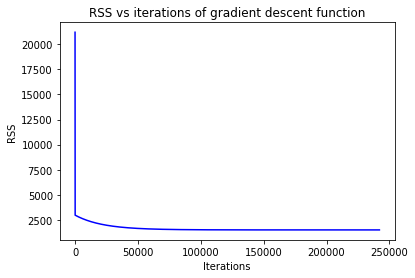

In [13]:
plt.plot(np.arange(len(cost_history)-1), cost_history[1:], 'b-')
plt.xlabel('Iterations')
plt.ylabel('RSS')
plt.title('RSS vs iterations of gradient descent function')

We can see that the first few iterations are extremely steep because our initial guess is quite far from the optimal solution. After a few steps it becomes stable and progresses smoothly towards the optimum.

## 4. Expansion to Multiple Features <a class="anchor" id="fourth-bullet"></a>

In many cases there are multiple descriptive features that can be correlated with the target feature. 

Example plots of some data with 2 features and 1 target feature:

Text(0.5,0.98,'Variation of y with 2 features')

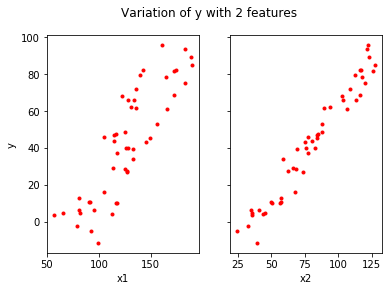

In [14]:
x1_values = np.linspace(0,100,num=50) + (np.random.random_sample((50,))*50) + 50 # create random x1 data
x2_values = np.linspace(0,100,num=50) +(np.random.random_sample(x1_values.shape)*20) + 20 # create random x2 data
y_3dvalues = -5 + (10*x1_values) + (3 * x2_values) + (np.random.random_sample((50,))*10) # create y data as a function of both
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,) 
ax1.plot(x1_values, y_data, 'r.')
ax1.set_xlabel('x1')
ax1.set_ylabel('y')
ax2.plot(x2_values, y_data, 'r.')
ax2.set_xlabel('x2')
f.suptitle('Variation of y with 2 features')

Text(0.5,0.966,'3D view of problem with 2 features')

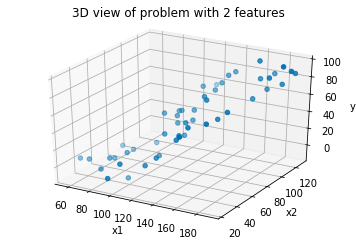

In [15]:
fig =plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1_values, x2_values, y_data)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
ax.set_title('3D view of problem with 2 features', y=1.05)

We could plot 2 independent lines of best fit, but then for a data point of ($x_{1}$,$x_{2}$) we could potentially calculate 2 very different values for y and how would we combine them? 

Instead we find the 3D plane that best fits **both** features at the same time. Now for any combination of ($x_{1}$,$x_{2}$) on the plane we will get a single estimate of y.

We need to make a change to our notation now to facilitate easy manipulation:
\begin{align}
y_i & = mx_i + c \\
&becomes \\
y_i & = w_o + w_1 x_i[1] + w_2 x_i[2] . . . . 
\end{align}

Where $w_{d}$ is the weight of the dth feature and $x_{i}[d]$ is the ith value of the dth feature. We can stack the $w_{d}$ values into a column vector, **w**, and we can stack observation $x_{i}$ into a matrix **H** that has i rows and d columns. The vector of predicted target values, **$\hat{Y}$** is therefore:
\begin{align}
\hat{Y} & = Hw\\
\end{align}

### RSS with matrix notation
Like before we are trying to minimise the RSS cost function. Now instead of :
\begin{equation*}
RSS = \sum_{i=1}^n(y_i - (m x_i + c))^2 \\
\end{equation*}
We are optimising:
\begin{equation*}
RSS = \sum_{i=1}^n(y_i - Hw)^2 \\
\end{equation*}
Which simplifies to:
\begin{equation*}
RSS = (Y - Hw)^T (Y-Hw)\\
\end{equation*}
The gradient of RSS is therefore:
\begin{equation*}
\nabla RSS = -2H^T (Y - Hw)
\end{equation*}
Setting this to zero to get the **closed form** solution we get:
\begin{equation*}
\hat{w} = (H^T H)^{-1} H^T Y
\end{equation*}

Which you will notivce has the inverse of $H^{T}H$ which is a dxd matrix. The complexity of calculating this inverse scales with the cube of the number of features (d). In our example case we should be able to calculate the closed form solution fairly easily:

In [16]:
def multi_reg_closed_form(x_matrix, y_values):
    intercept_column = np.ones(len(x_matrix)) # create a feature column of 1's for the intercept
    x_matrix = np.column_stack((intercept_column, x_matrix)) #stack the intercept column onto the front of the feature matrix
    first_term = np.linalg.inv(np.dot(np.transpose(x_matrix), x_matrix)) #calculate the inverse term
    second_term = np.dot(np.transpose(x_matrix), y_values) #calculate the next term
    weights = np.dot(first_term, second_term) # multiply the terms to get the weights
    
    print('Discovered weights are:')
    print(weights)
    
    return weights
    
weights = multi_reg_closed_form(np.column_stack((x1_values, x2_values)), y_3dvalues)

Discovered weights are:
[ -2.23404371  10.03403398   2.97200116]


Note that we gave the features coefficients of 10 and 3 respectively, so with the random variation we added we can see the closed form solution has worked. 

Let's visualise what this means:

Text(0.5,0.966,'3D view of calculated best fit plane')

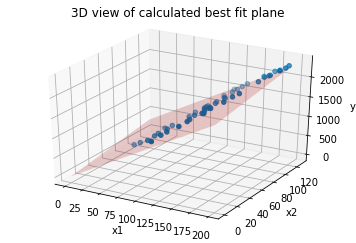

In [17]:
fig =plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1_values, x2_values, y_3dvalues) # plot the actual data
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')

xx, yy = np.meshgrid(range(200), range(120)) # create a meshgrid for the x and y range
z = weights[0]+ weights[1]*xx + weights[2]*yy # use our calculated weights to plot a plane

ax.plot_surface(xx,yy,z,alpha=0.2, color='red')
ax.set_title('3D view of calculated best fit plane', y=1.05)

Looks pretty good! Because the inverse operation is very intensive for large numbers of features, it is useful to also extend the Gradient descent  algorithm. We take the same approach as the single feature case where we calculate the gradient with the current parameters and then change the parameters iteratively by a function of the gradient at each iteration:
\begin{equation*}
w_{new} = w_{old} - \eta \nabla RSS \\
\nabla RSS = - 2 H^T (Y - Hw) \\
w_{new} = w_{old} + 2\eta H^T (Y - Hw)
\end{equation*}

One thing to note is that using the above equation would update every weight at the same time using the entire dataset, also known as **Batch Gradient Descent**. There can be issues with this: We need to multiply matrices together that have dimensions of the size of the data set. If we have a large number of data points then it could take a while to perform this calculation. 

An alternative is **Stochastic Gradient Descent** which only updates the weights based on 1 input data point at a time. The training data points are then iterated through randomly.

We will implement **Batch Gradient Descent** below:

In [18]:
def predict_multi(x_matrix, weights):
    """This function takes a matrix of features, adds a vector of 
    1's to the front to represent the 0th feature and then uses the weights
    to calculate predicted values."""
    intercept_features = np.ones(len(x_matrix)) # Create the 0th feature vector
    x_matrix = np.column_stack((intercept_features, x_matrix)) # Add to the feature matrix
    predictions = np.dot(x_matrix, weights) # calculate the product
    
    return predictions

In [19]:
def RSS_multi(y_values, predictions):
    """Computes RSS with slightly different inputs to the old function.
    Takes the true y values and the predicted y values"""
    residuals = y_values - predictions
    RSS = (residuals**2).sum()
    
    return RSS

In [20]:
def multi_batch_grad_descent(x_values, y_values, 
                        step_size=0.0000001, max_iters=1000000, tol = 0.00000001):
    """This function takes in feature matrix and y data points and uses batch
    gradient descent to iteratively improve the weight values.
    The step_size parameter controls the size of the iterative steps taken, whilst 
    max_iters provides a limit on the number of iterations that can be performed."""
    intercept_feature = np.ones(len(x_values)) # create 0th feature column
    x_matrix = np.column_stack((intercept_feature, x_values)) # stack onto input values
    weights = np.zeros(x_matrix.shape[1]) #create blank vector that is the length of number of features
    cost_history = []
    
    iteration = 0 # initialise a counter variable for iterations
    while iteration < max_iters: # keep iterating until we reach max_iterations
        
        # calculate predictions with current parameters
        predictions = predict_multi(x_values, weights)
       
        # calculate the update terms
        update_term = 2 * step_size* np.dot(np.transpose(x_matrix),y_values - predictions)
        
        
        # update weights
        weights += update_term
        
        # computer current cost for interest and keep a history
        cost = RSS_multi(y_values, predict_multi(x_values, weights))
        cost_history.append(cost)
        
        if iteration > 0: # after the first iteration, check the size of cost step taken
            if np.abs(cost_history[iteration] - cost_history[iteration-1]) < tol: # if the change in cost is less than the tolerance
                print('Converged on solution.') # tell the user that the function converged
                break # break out of the loop and return the parameters
            
        iteration += 1 # add one to the iteration counter on each pass through
        
    if iteration == max_iters: # can reach this point if we converged or reached max_iters  
        print('Maximum iterations reached without convergence. Try a different step size and tolerance.')
        
    print('Computed %d iterations.' % iteration)
    print('Weights on final iteration are:')
    print(weights)
    
    # return a tuple of (gradient, intercept)
    return(weights, cost_history)

In [21]:
weights, cost_history = multi_batch_grad_descent(np.column_stack((x1_values, x2_values)), y_3dvalues)

Maximum iterations reached without convergence. Try a different step size and tolerance.
Computed 1000000 iterations.
Weights on final iteration are:
[ -0.87516399  10.01929105   2.97931287]


Pretty similar to the values we got from the closed-form solution! But this method will work for problems with large numbers of features. Just as a check, let's import the sklearn linear regression function and see what weights it comes up with:

In [22]:
from sklearn.linear_model import LinearRegression # import the linear regression object
reg = LinearRegression() # instantiate with default parameters
reg.fit(np.column_stack((x1_values, x2_values)), y_3dvalues) # fit to our data
print(reg.intercept_, reg.coef_) # print the intercept followed by the coefficients

-2.23404371338 [ 10.03403398   2.97200116]


Very similar! For some reason my intercept term converges at a different value. I am measuring convergence by the change in the cost function between iterations, however a better way to do it would be to update one feature weight at a time and sum the **coefficient** changes for 1 whole sweep and use the magnitude of this to judge convergence.

I have now shown some of the methods for programatically fitting best lines/planes/hyperplanes to a data set. I intend to explore how we modify these algorithms to take into account regularization in my next notebook.

**Thanks for reading!**